In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind

## Import and merge data

In [2]:
# import metadata from both experiments
smds = pd.read_csv('../T1_SMDS_metadata_ms.txt', sep='\t')#, index_col=0)
srs = pd.read_csv('../T3_SRS_metadata_ms.txt', sep='\t')#, index_col=0)
# merge tables together on shared columns
table = pd.concat([smds,srs], join='outer')
smds.shape, srs.shape, table.shape

/Users/lisamarotz/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


((176, 28), (168, 34), (344, 43))

In [3]:
# seperate out raw and PMA-treated samples into their own tables
pmaT = table[table['processing']=='PMA']
rawT = table[table['processing']=='raw']
rawT.shape, pmaT.shape

((172, 43), (172, 43))

In [4]:
# reorganize table so that you have raw and PMA cell counts side by side
# subeset out the raw microbial load count data from the raw table and rename so column accordingly
raws = rawT[['saliva_sample_ID','FC_cells_per_ul_r1', 'FC_cells_per_ul_r2', 'FC_avg_cells_per_ul','FC_avg_cells_5_min']]
raws.columns=['saliva_sample_ID','raw_FC_cells_per_ul_r1', 'raw_FC_cells_per_ul_r2', 'raw_FC_avg_cells_per_ul','raw_FC_avg_cells_5_min']
# rename PMA count columns
pmaT.rename(index=str, columns={'FC_cells_per_ul_r1':'pma_FC_cells_per_ul_r1', 
                                'FC_cells_per_ul_r2':'pma_FC_cells_per_ul_r2',
                                'FC_avg_cells_per_ul':'pma_FC_avg_cells_per_ul',
                                'FC_avg_cells_5_min':'pma_FC_avg_cells_5_min'}, inplace=True)
# merge tables together on sample id, so that you have raw counts in the same row as live (PMA) counts
df = pd.merge(pmaT, raws, left_on='saliva_sample_ID', right_on='saliva_sample_ID')
df.shape

/Users/lisamarotz/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


(172, 47)

## Calculate various metrics as described in results section

In [5]:
# print number of participants
print('unique participants:', df.participant_id.nunique())

unique participants: 38


In [6]:
# print numer of unique saliva samples
print('unique saliva samples:', df.saliva_sample_ID.nunique())

unique saliva samples: 172


In [7]:
# print average salivary flow rate and standard error of the mean
print('average flow rate:',df['saliva_flow_rate_mL_per_min'].mean(),
      'standard error of the mean:', df['saliva_flow_rate_mL_per_min'].sem())

average flow rate: 0.4781744186046512 standard error of the mean: 0.02556852455847694


In [8]:
print('median flow rate:',df['saliva_flow_rate_mL_per_min'].median(),
      'min:',df['saliva_flow_rate_mL_per_min'].min(),
      'max:',df['saliva_flow_rate_mL_per_min'].max())

median flow rate: 0.38 min: 0.002 max: 1.56


In [9]:
# subset dataframe for male and female participants
f = df[df['gender']=='female']
m = df[df['gender']=='male']
# caclulate independent t-test score between male and female salivary flow rates
ttest_ind(f['saliva_flow_rate_mL_per_min'],m['saliva_flow_rate_mL_per_min'])

Ttest_indResult(statistic=-0.8477626720531806, pvalue=0.3977621577827327)

In [10]:
# calculate correlation between age and salivary flow rate
stats.pearsonr(df['saliva_flow_rate_mL_per_min'], df['age'])

(-0.0034418679313163413, 0.9642582327637883)

### Plot figure 2A

In [16]:
# add a general category for plotting
df['sample_type']='saliva'
# highlight samples collected immediately waking up and immediately after alcohol-free mouthwash rinse
df['color_code']=np.where(((df['Treatment_description']=='alcoholfree-mouthwash')&(df['collection_code']==2)), 
                          'alcoholfree-mouthwash', np.where((df['timepoint']==1), 'wakeup', 'other'))


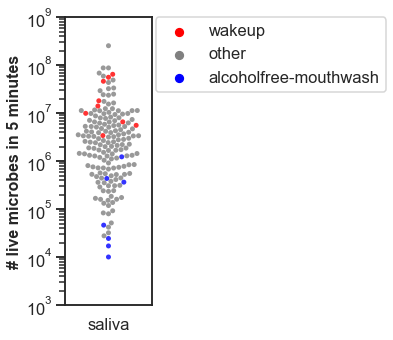

In [19]:
sns.set_style('ticks')
sns.set_context("talk")
fig = plt.figure() # create figure
rect = 0,0,.2,1 # create rectangle for the new axis
log_ax = fig.add_axes(rect) # create a new axis 
log_ax.set_yscale("log") # set y-axis to log scale
log_ax.set(ylim=(1000, 1000000000)) # set y-axis limits

# plot data!
sns.swarmplot(x='sample_type', y='pma_FC_avg_cells_5_min', data=df, hue='color_code', 
              alpha=0.8, size=5, palette=['red','gray','blue'])
# set labels and legend
log_ax.set_ylabel('# live microbes in 5 minutes', fontsize=16, fontweight='bold')
log_ax.set_xlabel('')
plt.tick_params(bottom=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [20]:
#fig.savefig('../../figures/number_live_microbes.png',bbox_inches='tight',dpi=500)

### Plot figure 2B

In [21]:
# add in percent alive by dividing live cells detected in 5 min by all cells (raw) detected in 5 min
df['PercAlive_5min'] = df['pma_FC_avg_cells_5_min'] / df['raw_FC_avg_cells_5_min']
# Set max % alive at 1
maxVal = 1
df['PercAlive_5min'].where(df['PercAlive_5min'] <= maxVal, maxVal, inplace=True) 

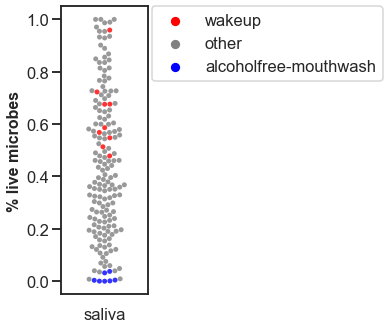

In [22]:
sns.set_style('ticks')
sns.set_context("talk")
fig = plt.figure() # create figure
rect = 0,0,.2,1 # create rectangle for the new axis
ax = fig.add_axes(rect) # create a new axis
# plot data!
sns.swarmplot(x='sample_type',y='PercAlive_5min', data=df, color='black', alpha=0.8, size=5,
              hue='color_code',palette=['red','gray','blue'])
# set labels
ax.set_ylabel('% live microbes', fontsize=16, fontweight='bold')
ax.set_xlabel('')
plt.tick_params(bottom=False)
plt.tick_params(bottom=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [23]:
# print min and max percent of live cells
df['PercAlive_5min'].min(), df['PercAlive_5min'].max()

(0.00010084534708337718, 1.0)

In [24]:
#fig.savefig('../../figures/percent_live_microbes.png', bbox_inches='tight', dpi=500)

### Plot figure 2C

In [25]:
# calculate cells per milliliter of saliva (right now it is in microliters)
df['raw_FC_avg_cells_per_mL'] = df['raw_FC_avg_cells_per_ul']*1000
df['pma_FC_avg_cells_per_mL'] = df['pma_FC_avg_cells_per_ul']*1000

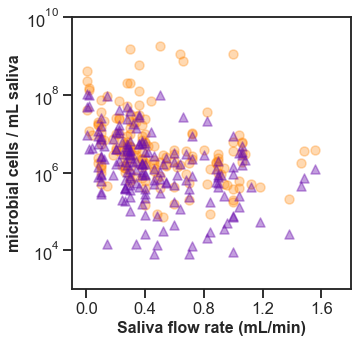

In [26]:
sns.set_style('ticks')
fig, ax1 = plt.subplots(figsize=[5,5])
# plot data!
ax1.scatter(x='saliva_flow_rate_mL_per_min',y='raw_FC_avg_cells_per_mL', data=df, color='#FF8300', alpha=0.3)
ax1.scatter(x='saliva_flow_rate_mL_per_min', y='pma_FC_avg_cells_per_mL', data=df, color='#6A0DAD', marker='^', alpha=0.4)
ax1.set(yscale="log") # set y-axis to log scale
# adjust labels
ax1.set_xlabel('Saliva flow rate (mL/min)', fontsize=16, fontweight='bold')
ax1.set_ylabel('microbial cells / mL saliva', fontsize=16, fontweight='bold')
ax1.set(ylim=(1e3,1e10), xlim=(-0.1,1.8))
ax1.set_yticks([1e4,1e6,1e8,1e10])
ax1.set_xticks([0,0.4,0.8,1.2,1.6])

In [27]:
#fig.savefig('../../figures/saliva_flow_v_number.png', bbox_inches='tight', dpi=500)

## Calculate correlation between salivary flow rate and log(microbial concentration)

In [28]:
ld = ['pma_FC_avg_cells_per_mL','raw_FC_avg_cells_per_mL']
dfc = df.dropna(subset=['saliva_flow_rate_mL_per_min','pma_FC_avg_cells_per_mL','raw_FC_avg_cells_per_mL'])
for i in ld:
    print(i, stats.pearsonr(dfc['saliva_flow_rate_mL_per_min'], np.log(dfc[i])))

pma_FC_avg_cells_per_mL (-0.3769676983510485, 3.73308402636047e-07)
raw_FC_avg_cells_per_mL (-0.3256411809518651, 1.3855668827992683e-05)
